# Start Dask

In [1]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

/anaconda3/envs/overscripted/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


This notebook uses the parquet produced by the "isJson_dataPrep.ipynb":
- ‘s0_domains_isJson_jsonKeys_md5_TLD.parquet'
	- It contains all the original 10% sample with extra columns.

# Objective
Show and compare between samples the presence and occurrence of operation/symbols/domain/tld. 

I'll be doing two of each graph to show the difference between the whole data and the filtered data by only rows that have the value_len above the mean

# Overview
### Operation
Most operation used across the entire sample is GET. 
99.67% of the valid JSONs has GET as operation. If filtered by values_len above the mean then all 100% of the valid JSONs are GET. 

### Symbols
The difference for the unique symbols counting for the whole sample and the filtered one is really big. The one thing I can say is that  'window.localStorage' is the one that produces most JSONs (65%) and ‘window.document.cookie' is the one responsible for 34% of the non-JSON, anything else may require further investigation and understanding. 

### Domain
'Baidu' has the most occurrences for valid JSON values (15%) but it's only in the 5th position when it comes to the values above the mean (5.9%).
‘Google.Analytics’ is the top one for the non-JSON values for both all values and bigger values.


### TLD
The TLD is more balanced between the non-JSON and JSON values, and the top ones remain for the filtered data. 


In [2]:
DIR = 'sample_0_prep/'

In [3]:
columns=['operation', 'symbol', 'script_domain', 'is_json', 'keys_md5', 'script_tld', 'value_len']
df = dd.read_parquet(DIR + 's0_domains_isJson_jsonKeys_md5_TLD.parquet',
                         engine='pyarrow',
                         columns=columns)
with ProgressBar():
    mean = df['value_len'].mean().compute()

df_a = df[df.value_len > mean]

[########################################] | 100% Completed |  6.8s


# Support code
This section is where some support code is placed. 
Some of the code here is where the math actually happen and the other section uses it. 

In [4]:
with ProgressBar():
    df_json = df[df.is_json == True].compute()
    df_other = df[df.is_json == False].compute()

[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  7.3s


In [5]:
with ProgressBar():
    df_a_json = df_a[df_a.is_json == True].compute()
    df_a_other = df_a[df_a.is_json == False].compute()

[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  6.8s


In [6]:
def calcUniquePercentual(df, column):
    v = df[column].value_counts()
    l = df[column].count()
    return v/l

In [7]:
def plotUsageComparation(df_json, df_other, column):
    nonjsons = calcUniquePercentual(df_other, column=column)
    jsons = calcUniquePercentual(df_json, column=column)
    p1 = pd.DataFrame({'json': jsons,'other':nonjsons}).sort_values('json', ascending=False)
    p1.plot(kind='bar')
    return p1

In [8]:
def plotTopUsageComparation(df_json, df_other, column, top):
    nonjsons = calcUniquePercentual(df_other, column=column)
    jsons = calcUniquePercentual(df_json, column=column)
    
    p1 = pd.DataFrame({'json': jsons,'other':nonjsons})
    top_json = p1.sort_values('json', ascending=False).head(top)
    top_other = p1.sort_values('other', ascending=False).head(top)
    tops = pd.concat([top_json, top_other]).drop_duplicates()
    tops.plot(kind='bar')
    return tops

In [41]:
def plotUniqueValuesComparation(df_json, df_other, column):
    nonjsons = calcUniquePercentual(df_other, column=column)
    jsons = calcUniquePercentual(df_json, column=column)
    
    #Value counts
    count_nonjson = len(nonjsons)
    count_json = len(jsons)
    p1 = pd.DataFrame([count_json, count_nonjson], 
                      index= [ 'Json', 'Other' ], 
                      columns=['Value Counts'])
    p1.plot(kind='bar')
    print("There are {} unique {} present on the non-json dataset and {} on the JSONs".format(count_nonjson,
                                                                                       column,
                                                                                       count_json))
    return p1

# OPERATION:

The operation columns can have 3 different values 
 - GET
 - SET
 - CALL

We can see below that pretty much all<sup>[1]</sup> JSONs have the operation GET when the whole sample is analysed and ALL JSONs have GET when we filter the sample to values above the mean. 
The GET operation is the most common among the non-json values as well. 

---
<small> For futher investigation:  
1. Are the JSONs that have SET as operation really JSON? Are they false positives? Why are they different? </small>

### Full sample:

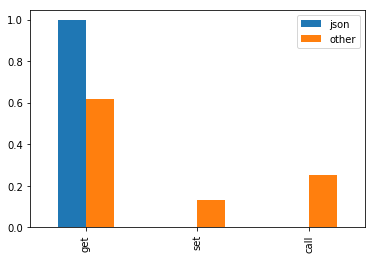

In [25]:
p1 = plotUsageComparation(df_json, df_other, 'operation')

### Above the mean sample:

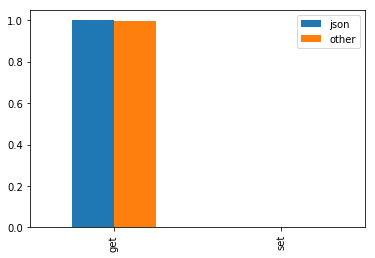

In [26]:
p2 = plotUsageComparation(df_a_json, df_a_other, 'operation')

,json,other,json,other
get,0.996719,0.616728,1.0,0.999047
set,0.003281,0.131672,NaN,0.000953
call,NaN,0.251601,NaN,NaN


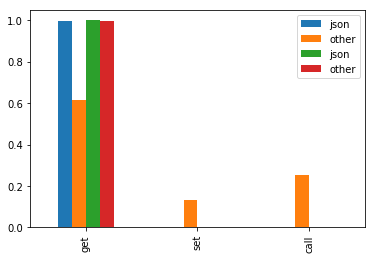

In [34]:
p3 = pd.concat([p1, p2], axis=1, sort=False).drop_duplicates()
p3.plot(kind='bar')
p3

# SYMBOLS
There is a pretty big difference<sup>[1]</sup> of unique values that appear on the whole sample and the filtered sample.  
For the whole sample there is as much as 245 different symbols on the non json values, but it is drastically reduced to 2 symbols<sup>[2]</sup> for the filtered sample with only value_len above the mean, most being 'window.document.cookie' (99%).   
For the valid JSONs there are only 12 symbols total reduced to 5 symbols<sup>[3]</sub>.  

---
<small> For futher investigation: 
1. Why is the difference so big? does it have any meaning?
2. What are the meaning of the 2 symbols of the non-json? are they special? why only 2? Why 'window.document.cookie'?
3. Why these 5 symbols? what do they do? what do they represent?</small>



### Full Sample:

There are 245 unique symbol present on the non-json dataset and 12 on the JSONs


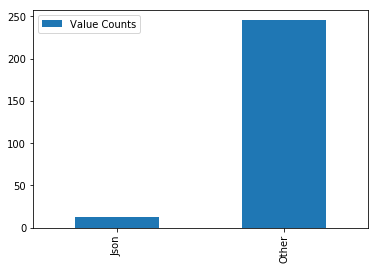

In [42]:
p1 = plotUniqueValuesComparation(df_json, df_other, 'symbol')

,json,other
window.localStorage,0.653011,0.020276
window.sessionStorage,0.307743,0.009565
HTMLCanvasElement.style,0.020859,0.000780
window.document.cookie,NaN,0.342406
window.navigator.userAgent,NaN,0.149935
window.Storage.getItem,NaN,0.101712


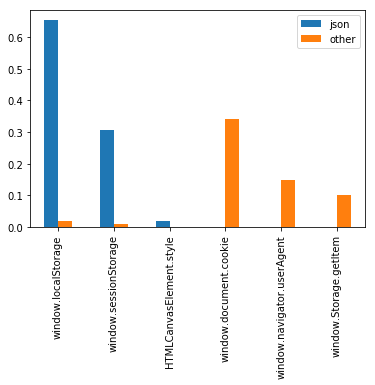

In [13]:
plotTopUsageComparation(df_json, df_other, 'symbol', 3)

### Above the mean Sample:

There are 2 unique symbol present on the non-json dataset and 5 on the JSONs


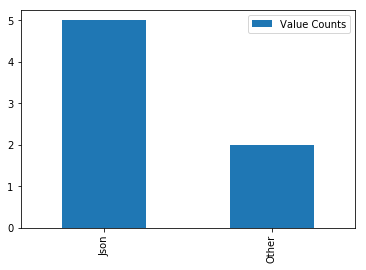

In [43]:
p2 = plotUniqueValuesComparation(df_a_json, df_a_other, 'symbol')

,json,other
window.localStorage,0.822601,NaN
window.sessionStorage,0.171297,NaN
HTMLCanvasElement.ownerDocument,0.004006,NaN
window.name,0.002076,0.000182
HTMLCanvasElement.style,0.000021,NaN
window.document.cookie,NaN,0.999818


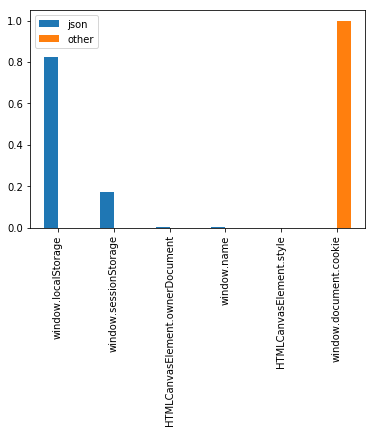

In [15]:
plotUsageComparation(df_a_json, df_a_other, 'symbol')

,Value Counts,Value Counts
Json,12,5
Other,245,2


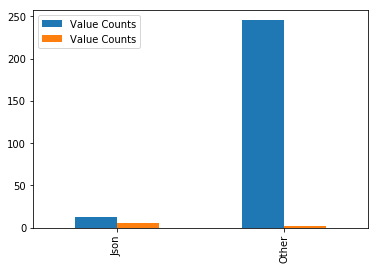

In [45]:
p3 = pd.concat([p1, p2], axis=1, sort=False).drop_duplicates()
p3.plot(kind='bar')
p3

# DOMAINS

Again, the difference for unique values for the whole sample and the filtered one is really big. Only 7.2%<sup>[1]</sup> of the values remain on the filtered sample for the non-JSON values and  30% for the JSON’s. 

---
<small> For futher investigation: 
1. Only few of domains produce bigger values, why? Do they have something in common? Does that mean that some domains only produce bigger values?  
    
2. What are the top domains commonly used for?</small>

### Full Sample

There are 11166 unique script_domain present on the non-json dataset and 3507 on the JSONs


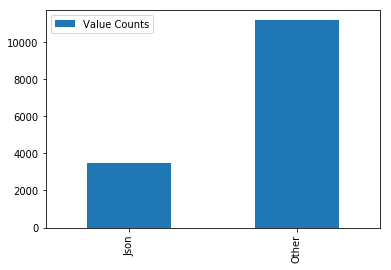

In [16]:
plotUniqueValuesComparation(df_json, df_other, 'script_domain')

,json,other
baidu.com,0.156162,0.029125
cloudfront.net,0.082307,0.031655
rambler.ru,0.048266,0.010561
google-analytics.com,0.000005,0.121869
yandex.ru,0.021904,0.030423


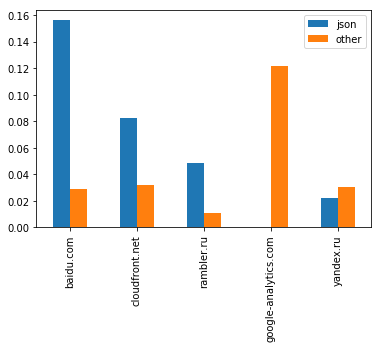

In [17]:
plotTopUsageComparation(df_json, df_other, 'script_domain', 3)

### Above the mean Sample

There are 811 unique script_domain present on the non-json dataset and 1051 on the JSONs


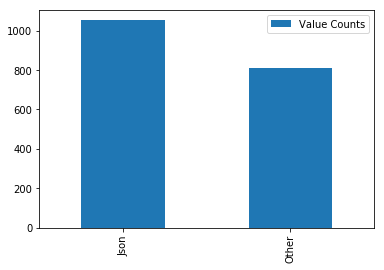

In [18]:
plotUniqueValuesComparation(df_a_json, df_a_other, 'script_domain')

,json,other
sociaplus.com,0.089909,0.006558
tiqcdn.com,0.081866,0.037636
twimg.com,0.079437,NaN
google-analytics.com,0.000005,0.100417
adobedtm.com,0.008422,0.050673
yoox.biz,0.001498,0.041437


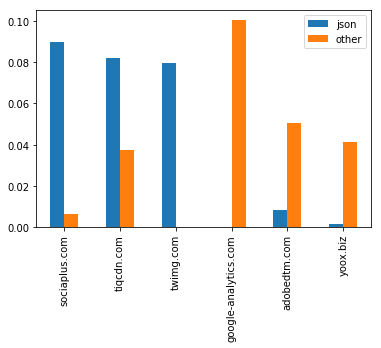

In [19]:
plotTopUsageComparation(df_a_json, df_a_other, 'script_domain', 3)

# TLD
All top 3 domains are the same for both valid JSON and non-JSON, and they remain for the filtered data. But the are some domains that only appear in the whole sample producing only smaller values<sup>[1]</sup>.

---
<small> For futher investigation: 
1. Why are there TLD that only produces smaller values? What are they? Are there also the ones that only produces bigger values?  </small>

There are 248 unique script_tld present on the non-json dataset and 141 on the JSONs


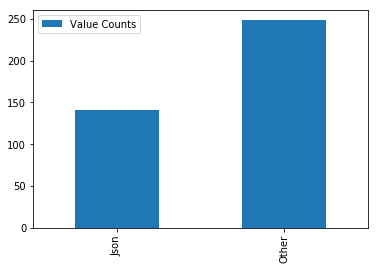

In [20]:
plotUniqueValuesComparation(df_json, df_other, 'script_tld')

,json,other
com,0.646485,0.650045
net,0.143621,0.170509
ru,0.082325,0.053212
fr,0.023078,0.006061
cn,0.006060,0.014413


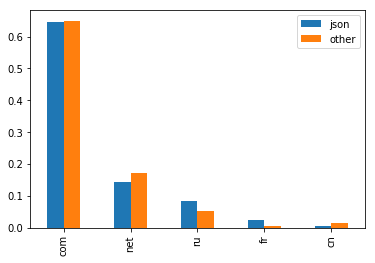

In [21]:
plotTopUsageComparation(df_json, df_other, 'script_tld', 4)

There are 52 unique script_tld present on the non-json dataset and 89 on the JSONs


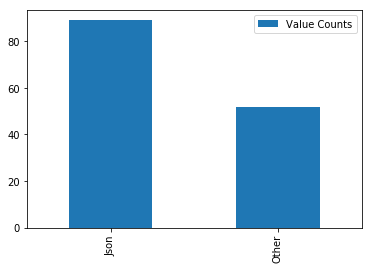

In [22]:
plotUniqueValuesComparation(df_a_json, df_a_other, 'script_tld')

,json,other
com,0.705027,0.627121
net,0.150878,0.190486
ru,0.055486,0.002650
biz,0.001498,0.041437


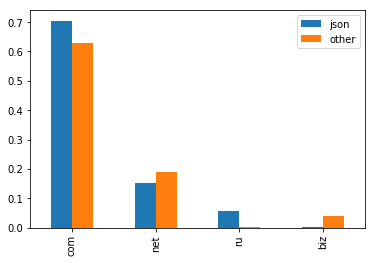

In [23]:
plotTopUsageComparation(df_a_json, df_a_other, 'script_tld', 3)